# <b>QF627 - Developing Algorithmic Trading Strategies on SPY

## <b>Author</b> :
>1.) Cai Shuhan (ID : 01438483)\
>2.) Saran Somboonsiripok (ID : 01475352)\
>3.) Song Yang (ID : 01491690)\
>4.) Toh Huiting (ID : 01473581)

<b>Using SPY data, from Nov-2004 through Oct-2023, a blend of supervised machine learning techniques and technical analysis were employed to come up with 3 profitable strategies.

###  <a id = "top">Bookmarks</a>  

#### [1. Part 1: Strategies](#p1)

><font color = red> Different strategies explored ( Momentum, Mean reversion and Machine Learning) </font>

#### [2.Part 2: Backtesting](#p2)

><font color = red> The performance matrix, Sharpe, CAGR and max-drawdown </font>

#### [3. Part 3: Executive Summary](#p3)

><font color = red> Summary of the 3 chosen strategies </font>

#### [4. Part 4: Self-Critique](#p4)

><font color = red> Criticise own strategies, the situations it will fail </font>

#### [5. Contribution Statement](#p5)

><font color = red> Team member contribution </font>

#### [6. Appendix](#p6)

><font color = red> The strategies that we have tested but were not able to beat the market and/or too risky </font>

## <a id = "p1">1. </a> <font color = "green"> Part1: Strategies</font>  
[back to table of contents](#top)

> <b>1.1 ) Import necessary libraries and data

In [54]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

np.set_printoptions(precision = 3)
plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import bs4 as bs
import requests
import yfinance as yf
import datetime
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
(yf.pdr_override())
from scipy.cluster.hierarchy import dendrogram, linkage, ward
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

[*********************100%%**********************]  1 of 1 completed
Cumulative return of buy and hold is 275.97770 %
Max drawdown of buy and hold is 1.08918
Max drawdown period of buy and hold is 1983 days, 0:00:00
Sharpe ratio for buy and hold is 0.44596
CAGR for buy and hold is 0.06903


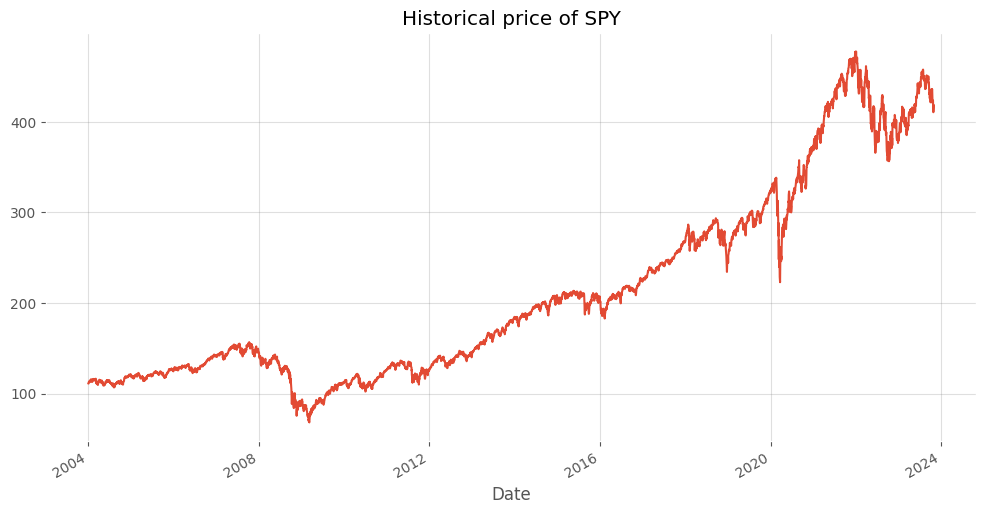

In [55]:
# Data

start = dt.date(2004,1,1)
end = dt.date(2023,11,1)
ticker = 'SPY'
price = 'Close'
capital = 100000

SPY_original = pdr.get_data_yahoo(ticker, start = start, end = end)

SPY_original['normal_return'] = SPY_original[price].pct_change()
SPY_original["log_returns"] =np.log(SPY_original[price] /SPY_original[price].shift(1))
SPY_original["cumulative_returns"] = SPY_original[['log_returns']].cumsum().apply(np.exp)
spy_cumulative_return = (SPY_original["cumulative_returns"][-1] - 1) * 100
print('Cumulative return of buy and hold is {:.5f} %'.format(spy_cumulative_return))

# calculate maximum drawdown
SPY_original["max_gross_performance"] = SPY_original["cumulative_returns"].cummax()
drawdown = SPY_original["max_gross_performance"] - SPY_original["cumulative_returns"]
spy_mdd = drawdown.max()
periods =\
(
    drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    drawdown[drawdown == 0].index[   : -1].to_pydatetime()
)
spy_mdp = periods.max()
print('Max drawdown of buy and hold is {:.5f}'.format(drawdown.max()))
print('Max drawdown period of buy and hold is {}'.format(periods.max()))


# calculate sharpe ratio
spy_sharpe = np.sqrt(252) * (SPY_original['normal_return'].mean() / SPY_original['normal_return'].std())
print('Sharpe ratio for buy and hold is {:.5f}'.format(spy_sharpe))

# cagr
days = (SPY_original.index[-1] - SPY_original.index[0]).days
spy_cagr = ((SPY_original[price][-1] / SPY_original[price][0]) **(365 / days))-1
print('CAGR for buy and hold is {:.5f}'.format(spy_cagr))

SPY_original[price].plot(figsize = [12,6])
plt.title('Historical price of SPY')
plt.show()



> <b>1.2) Strategy A : RSI with predicted market movements using Logistic Regression (RSI windows = 14, Lags of Logistic regression = 4)

In [56]:
# 1.) Develop function for RSI strategy

def RSI_long_short(df_original, window, threshold):
    df = df_original.copy()
    diffs   = df[price].diff().dropna()
    rsi     = pd.Series(0, index=diffs.index[window - 1:])
    initial_period = diffs.iloc[:window]
    avg_gain       = (initial_period * (initial_period > 0)).mean()
    avg_loss       = -(initial_period * (initial_period < 0)).mean()
    rs             = avg_gain / max(avg_loss, 1e-10)
    rsi.iloc[0]    = 100 - 100 / (1 + rs)
    for i, diff in enumerate(diffs.iloc[window:], 1):
        avg_gain    = (avg_gain * (window - 1) + max(diff, 0)) / 14
        avg_loss    = (avg_loss * (window - 1) + max(-diff, 0)) / 14
        rs          = avg_gain / max(avg_loss, 1e-10)
        rsi.iloc[i]   = 100 - 100 / (1 + rs)
    df['RSI'] = rsi
    df['RSI_position'] = np.nan
    df['RSI_position'] = np.where(df['RSI'] < threshold, 1, -1)
    df['RSI_return'] =  df['RSI_position'].shift(1) * df['log_returns']
    df['RSI_Cumulative_Return'] = df['RSI_return'].cumsum().apply(np.exp)
    df['RSI_max_gross'] = df['RSI_Cumulative_Return'].cummax()
    drawdown = df['RSI_max_gross'] - df['RSI_Cumulative_Return']
    df.dropna(inplace = True)
    # sharpe ratio
    sharpe = np.sqrt(252) * ((df['RSI_return'].apply(np.exp)-1).mean() / ((df['RSI_return'].apply(np.exp)-1).std()))
    # CAGR
    days = (df.index[-1] - df.index[0]).days
    cagr = ((df['RSI_Cumulative_Return'][-1] / df['RSI_Cumulative_Return'][0])**(365.0/days))-1
    return df, df[['RSI_return']].sum().apply(np.exp), drawdown.max(), sharpe, cagr

In [57]:
# 2.) Testing to obtain optimal RSI threshold for window = 14

SPY = SPY_original.copy()
RSI_ret_long_short = {}
RSI_range = range(16,88,1)
for i in RSI_range:
    RSI_ret_long_short[i] = RSI_long_short(SPY, 14, i)[1].values[0]
RSI_ret_long_short_series = pd.Series(RSI_ret_long_short)

print('Maximum cumulative return is {}'.format(RSI_ret_long_short_series.max()))
print('At threshold of strategy equals to {}'.format(RSI_ret_long_short_series.idxmax()))

Maximum cumulative return is 5.2541287298087225
At threshold of strategy equals to 65


In [58]:
# 3.) Implement function for RSI strategy combining with signal filter by
# predicted market movements by Logistic Regression.

def RSI_long_short_ml(df_original, window = 14, threshold = 65, lags = 4):

    # rsi_strategy
    df = df_original.copy()
    diffs   = df[price].diff().dropna()
    rsi     = pd.Series(0, index=diffs.index[window - 1:])
    initial_period = diffs.iloc[:window]
    avg_gain       = (initial_period * (initial_period > 0)).mean()
    avg_loss       = -(initial_period * (initial_period < 0)).mean()
    rs             = avg_gain / max(avg_loss, 1e-10)
    rsi.iloc[0]    = 100 - 100 / (1 + rs)
    for i, diff in enumerate(diffs.iloc[window:], 1):
        avg_gain    = (avg_gain * (window - 1) + max(diff, 0)) / 14
        avg_loss    = (avg_loss * (window - 1) + max(-diff, 0)) / 14
        rs          = avg_gain / max(avg_loss, 1e-10)
        rsi.iloc[i]   = 100 - 100 / (1 + rs)
    df['RSI'] = rsi
    df['RSI_position'] = np.nan
    df['RSI_position'] = np.where(df['RSI'] < threshold, 1, -1)
    
    # logistic regression
    cols = []
    for lag in range(1, lags +1):
        col = 'lag_{}'.format(lag)
        df[col] = df['log_returns'].shift(lag)
        cols.append(col)
    M =linear_model.LogisticRegression(solver = "lbfgs",
                            C = 1e7,
                            multi_class = "auto",
                            max_iter = 1000)
    df.dropna(inplace = True)
    M.fit(df[cols],np.sign(df["log_returns"]))
    df['ret_prediction'] = M.predict(df[cols])

    # combining signal
    df['rsi_ML_positions'] = np.nan
    bullish_1 = df['RSI_position'] == 1
    bullish_2 = df['ret_prediction'] == 1
    bearish_1 = df['RSI_position'] == -1
    bearish_2 = df['ret_prediction'] == -1
    df['rsi_ML_positions'] = np.where(bullish_1 & bullish_2, 1,np.nan)
    df['rsi_ML_positions'] = np.where(bearish_1 | bearish_2, -1,df['rsi_ML_positions'])
    df['rsi_ML_positions'].ffill(inplace = True)
    df['rsi_ML_positions'] = df['rsi_ML_positions'].fillna(0)

    df['strategy_return'] = df['rsi_ML_positions'].shift(1) * df['log_returns']
    df['rsi_ML_Cumulative_Return'] = df['strategy_return'].cumsum().apply(np.exp)
    df.dropna(inplace = True)

    # drawdown
    df['rsi_ML_max_gross'] = df['rsi_ML_Cumulative_Return'].cummax()
    drawdown = df['rsi_ML_max_gross'] - df['rsi_ML_Cumulative_Return']
    periods = drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime() -\
            drawdown[drawdown == 0].index[   : -1].to_pydatetime()

    # sharpe ratio
    sharpe = np.sqrt(252) * ((df['strategy_return'].apply(np.exp)-1).mean() / ((df['strategy_return'].apply(np.exp)-1).std()))

    # CAGR
    days = (df.index[-1] - df.index[0]).days
    cagr = (((df['rsi_ML_Cumulative_Return'][-1]/ df['rsi_ML_Cumulative_Return'][0]))**(365 / days))-1
    return df, df[['strategy_return']].sum().apply(np.exp),drawdown.max(), periods.max(), sharpe, cagr

> <b>1.3) Strategy B : Stochastic RSI (K = 36 days and 8-days window RSI)

In [59]:
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    
    STOD = STOK.rolling(3).mean()
    return STOD

def RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [60]:
# Developing function for strategy 

def stochasticsRSI(df,k_num,rsi_num):

    GE =df.copy(deep=False)
    GE =GE.rename(columns = {"Close": "PRICE"})
    
    GE["RETURN"] =np.log(GE["PRICE"]/GE["PRICE"].shift(1))
    #COLS = ["K","D"]
    GE["K"] = STOK(GE["PRICE"], GE["Low"], GE["High"], k_num)
    GE["RSI"] = RSI(GE["K"], rsi_num)
    GE = GE.dropna()
    
    mask_s=((GE["RSI"]>=80)&(GE["RSI"].shift(1)<80))
    mask_b=((GE["RSI"]<=20)&(GE["RSI"].shift(1)>20))
   
    
    GE['PREDICTION']=np.where(mask_b,1,np.NAN)
    GE['PREDICTION']=np.where(mask_s,-1,GE['PREDICTION'])
    GE['PREDICTION']=GE['PREDICTION'].ffill()
 
    GE['PREDICTION']= GE['PREDICTION'].fillna(0)
    GE["Actions"] =GE['PREDICTION'].diff().fillna(GE['PREDICTION'])
    GE["strategy_returns"]=GE["PREDICTION"].shift(1)*GE["RETURN"]
    GE["strategy_returns"]=GE["strategy_returns"].fillna(0)
    GE["Cum_Ideal_strategy_ret"]=GE["strategy_returns"].cumsum().apply(np.exp)
    GE['max_gross_performance']=GE["Cum_Ideal_strategy_ret"].cummax()
    drawdown = GE["max_gross_performance"] - GE["Cum_Ideal_strategy_ret"]
    periods =drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()-drawdown[drawdown == 0].index[   : -1].to_pydatetime()
    
    mean1=np.exp(GE[["strategy_returns"]].mean()*252) - 1
    stdev1=GE[["strategy_returns"]].std()* 252** 0.5
    Sharpe =mean1/ stdev1
    
    days =(GE.index[-1] - GE.index[0]).days
    CAGR =(np.exp(GE["Cum_Ideal_strategy_ret"][-1]) / np.exp(GE["Cum_Ideal_strategy_ret"][0]))**(365.0/days) - 1
    
    GE['year']=GE.index.year
    annual_returns=GE.groupby(by=['year'])['strategy_returns'].sum().apply(np.exp).reset_index()
    annual_returns['Percen_returns']=(annual_returns['strategy_returns']-1)*100
    volatility_array=GE.groupby(by=['year'])['strategy_returns'].std().reset_index()
    annual_returns['Volatilty']=volatility_array['strategy_returns']

    
    return Sharpe[0],(GE["Cum_Ideal_strategy_ret"][-1]-1)*100,drawdown.max(),periods.max(),CAGR,GE

> <b>1.4) Strategy C : Money Flow Index (window = 14 days, threshold = 80)

In [61]:
def get_MFI(stock):
    stock["typical_price"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
    stock["Money_flow"] = stock["typical_price"].multiply(stock["Volume"])
    stock["Pos_flow"] = np.where(stock["Close"] > stock["Close"].shift(1), stock["Money_flow"],0)
    stock["Neg_flow"] = np.where(stock["Close"] < stock["Close"].shift(1), stock["Money_flow"],0)
    pos_14 = stock["Pos_flow"].rolling(window = 14).sum()
    neg_14 = stock["Neg_flow"].rolling(window = 14).sum()
    ratio = pos_14 / neg_14
    return 100 - 100 / (1 + ratio)

In [62]:
SPY = SPY_original.copy()

SPY["MFI"] = get_MFI(SPY)
SPY["MFI_position"] = np.where(SPY["MFI"] > 80, -1, 1)
SPY["MFI_return"] = SPY["MFI_position"].shift(1) * SPY["log_returns"]
SPY["MFI_cum_return"] = SPY["MFI_return"].cumsum().apply(np.exp)
SPY["MFI_capital"] = capital * SPY["MFI_cum_return"]

sharpe = np.sqrt(252) * SPY["MFI_return"].mean() / SPY["MFI_return"].std()
days = (SPY.index[-1] - SPY.index[0]).days
cagr = (SPY["Close"][-1] / SPY["Close"][0]) ** (365.0/days) - 1

SPY["HWM"] = SPY["MFI_cum_return"].cummax()
drawdown = SPY["HWM"] - SPY["MFI_cum_return"]

periods =\
(
    drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    drawdown[drawdown == 0].index[   : -1].to_pydatetime()
)

## <a id = "p2">2. </a> <font color = "green"> Part2: Backtesting </font>  
[back to table of contents](#top)

> <b>2.1) Strategy A : RSI with predicted market movements using Logistic Regression

For strategy A: the performance measurements are as follows :
Return of strategy: 718.02449 %
Sharpe ratio : 0.65050
CAGR : 0.11284
Max drawdown : 240.13132 %
Max drawdown period : 591 days, 0:00:00
Final amount of capital : 818024.49 $


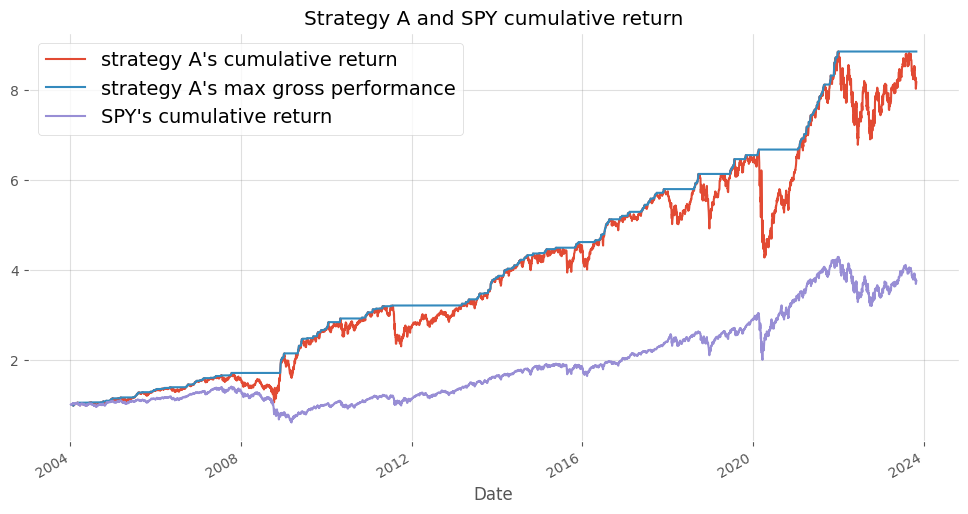

In [63]:
st1_df, st1_cumulative_return, st1_mdd, st1_mdp, st1_sharpe, st1_cagr =\
     RSI_long_short_ml(SPY_original, window = 14, threshold = 65, lags = 4)

print('For strategy A: the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format((st1_cumulative_return.values[0] - 1)*100))
print('Sharpe ratio : {:.5f}'.format(st1_sharpe))
print('CAGR : {:.5f}'.format(st1_cagr))
print('Max drawdown : {:.5f} %'.format(st1_mdd * 100))
print('Max drawdown period : {}'.format(st1_mdp))
print('Final amount of capital : {:.2f} $'.format(capital * st1_cumulative_return.values[0]))

st1_df['rsi_ML_Cumulative_Return'].plot(figsize = [12,6],label = "strategy A's cumulative return")
st1_df['rsi_ML_max_gross'].plot(label = "strategy A's max gross performance")
SPY_original['cumulative_returns'].plot(label = "SPY's cumulative return")
plt.title('Strategy A and SPY cumulative return')
plt.legend()
plt.show()


> <b>2.2) Strategy B : Stochastic RSI (K = 36 days and 8-days window RSI)

For strategy B: the performance measurements are as follows :
Return of strategy: 963.72303 %
Sharpe ratio : 0.67045
CAGR : 0.63229
Max drawdown : 308.50483 %
Max drawdown period : 441 days, 0:00:00
Final amount of capital : 1063723.03 $


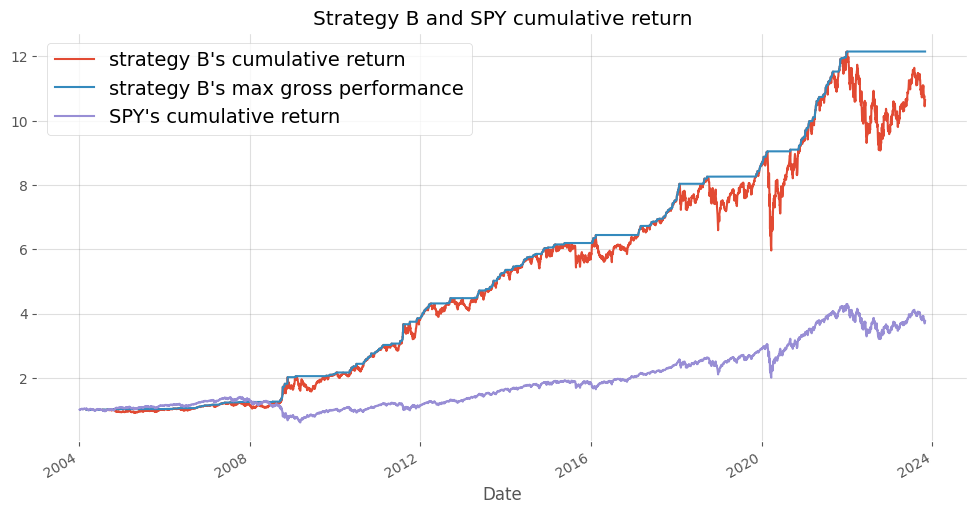

In [64]:
st2_sharpe, st2_cumulative_return, st2_mdd, st2_mdp, st2_cagr, st2_df = stochasticsRSI(SPY,36,8)

print('For strategy B: the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format(st2_cumulative_return))
print('Sharpe ratio : {:.5f}'.format(st2_sharpe))
print('CAGR : {:.5f}'.format(st2_cagr))
print('Max drawdown : {:.5f} %'.format(st2_mdd*100))
print('Max drawdown period : {}'.format(st2_mdp))
print('Final amount of capital : {:.2f} $'.format(capital * st2_df['Cum_Ideal_strategy_ret'][-1]))

st2_df['Cum_Ideal_strategy_ret'].plot(figsize = [12,6],label = "strategy B's cumulative return")
st2_df['max_gross_performance'].plot(label = "strategy B's max gross performance")
SPY_original['cumulative_returns'].plot(label = "SPY's cumulative return")
plt.title('Strategy B and SPY cumulative return')
plt.legend()
plt.show()

> <b>2.3) Strategy C : Money Flow Index (window = 14 days, threshold = 80)

For strategy C: the performance measurements are as follows :
Return of strategy: 315.98393 %
Sharpe ratio : 0.37668
CAGR : 0.07390
Max drawdown : 120.50801 %
Max drawdown period : 2039 days, 0:00:00
Final amount of capital : 415983.93 $


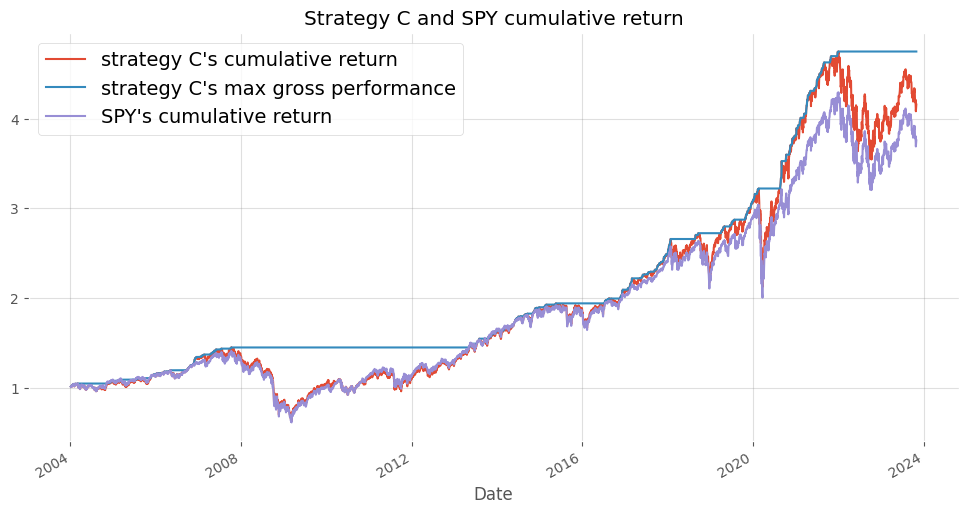

In [65]:
st3_sharpe = np.sqrt(252) * SPY["MFI_return"].mean() / SPY["MFI_return"].std()
days = (SPY.index[-1] - SPY.index[0]).days
st3_cagr = (SPY["MFI_cum_return"][-1] / SPY["MFI_cum_return"][1]) ** (365.0/days) - 1
st3_cumulative_return = (SPY["MFI_cum_return"][-1] - 1) * 100
st3_last_capital = SPY["MFI_capital"][-1]

SPY["HWM"] = SPY["MFI_cum_return"].cummax()
drawdown = SPY["HWM"] - SPY["MFI_cum_return"]

periods =\
(
    drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    drawdown[drawdown == 0].index[   : -1].to_pydatetime()
)

st3_mdd = drawdown.max()
st3_mdp = periods.max()

print('For strategy C: the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format(st3_cumulative_return))
print('Sharpe ratio : {:.5f}'.format(st3_sharpe))
print('CAGR : {:.5f}'.format(st3_cagr))
print('Max drawdown : {:.5f} %'.format(st3_mdd * 100))
print('Max drawdown period : {}'.format(st3_mdp))
print('Final amount of capital : {:.2f} $'.format(st3_last_capital))

SPY['MFI_cum_return'].plot(figsize = [12,6],label = "strategy C's cumulative return")
SPY['HWM'].plot(label = "strategy C's max gross performance")
SPY_original['cumulative_returns'].plot(label = "SPY's cumulative return")
plt.title('Strategy C and SPY cumulative return')
plt.legend()
plt.show()

## <a id = "p3">3. </a> <font color = "green"> Part3: Executive Summary </font>  
[back to table of contents](#top)

<b>3.1) Strategy A : RSI with predicted market movements using Logistic Regression

> The strategy started by determining the optimal threshold for RSI strategy by using for loop to iterate over different values of threshold at RSI windows = 14. The results of iteration showed that determining threshold at 65, then short the index when RSI value is higher than threshold and long the index when RSI value is lower yielded the highest cumulative return at 425.41%.

>After obtaining positions from RSI strategy at optimal threshold, the predicted market directions are also determined by using Logistic regression on signs (+,-) of SPY's log return. The explanatory variables of the models are 4 first lags of SPY's log return itself.

>The predicted market movements from Logistic regression are used to filter the positions obtained from RSI strategy with the bullish and bearish conditions as follows:

>Long signal : enter long position when the value of RSI is less than threshold (65) <b>AND</b> the predicted market movement on that day is positive (predicted value = +1).

>Short signal : enter short position when the value of RSI is more than threshold <b>OR</b> the predicted market movement on that day is negative (predicted value = -1).

>With this strategy, the cumulative return at 718.02449 % was yield over the investment horizon. The Sharpe ratio of strategy return is 0.65050 and CAGR is 0.11284. Max drawdown equals to 240.13132 % with longest drawdown period of 591 days. The final capital is $ 818,024.49

<b>3.2) Strategy B : Stochastic RSI (K = 36 days and 8-days window RSI)

> For Stochastic RSI: Instead of using direct close price in RSI, we used stochastic oscillator %k as input to the RSI formula
The inputs: Lookback period of 36 days to calculate stochastic oscillator %k and  window period of 8 days for the RSI formula which is calculated on this 36 days %k. 

>Long Signal: Long when RSI>80 
>Short Signal: Short when RSI<20

>With this strategy, the cumulative return at 963% was yield over the investment horizon. The Sharpe ratio of strategy return is 0.67 and CAGR is 0.63. Max drawdown equals to 308% with longest drawdown period of 441 days. The final capital is $ 1,063,723.03

<b>3.3) Strategy C : Money Flow Index (window = 14 days, threshold = 80)

> Initial idea was to use patterns in volume change to generate trading signals. Unlike price whose increments indicate a bullish market and drops indicate bearish market, volume change itself does not give clear picture of market condition. When volume goes up dramatically, it can be either bullish or bearish sign. Hence, we would like to use a indicator that combines price and volume. Based on experience and trials, lagging period of 14 and threshold of 80 were chosen.

> Short signal: Short when MFI>80

> The MFI strategy give a cumulative return of 316% over 20 years of trading. The Sharpe ratio of 0.38 and CAGR of 0.07 have been obtained. Max drawdown is 120.51% with longest drawdown period of 2039 days. The final capital is $ 415,983.93


## <a id = "p4">4. </a> <font color = "green"> Part4: Self-Critique </font>  
[back to table of contents](#top)

#### Overall Assessment

>These are the following points noted in our assessment. The cumulative return here does not reflect commission fees, market  impact costs and dividends impact.  Another point is execution exactly at close price during actual trading execution might be difficult.  We noticed that on the overall, the index is trading upwards and  RSI related strategies seem to work in this case compared to MACD. This could be because MACD has more false signals and hence, affecting strategy returns.

<b>4.1) Strategy A : RSI with predicted market movements using Logistic Regression

> For strategy A, even though the cumulative return yielded by this strategy was significantly greater than SPY's return over the investment horizon, the most important bias lies in the way this strategy was constructed which will effect its performance when being used in real trade is <b> Data-mining bias </b>.

> As the optimal RSI threshold (at 65) was determined by the historical data, there is no evidence that this optimal threshold will yield out-performed return for the future data unless out-of-sample testing is applied.

> The same problem also lies on the way logistic regression model in this strategy was constructed. As the only set of data being used was historical data and there was no out-of-sample testing conducted. The economic significance of this strategy is still ambiguous.

> To conclude, although this strategy worked well in backtesting with historical data from 2004 to 2023, the performance of the strategy when using it in real-time trading is questionable. Out-of-sample testing should be performed to test for the economic significance of the strategy before applying it to the real-world trading.

<b>4.2) Strategy B : Stochastic RSI (K = 36 days and 8-days window RSI)

> For Stochastic RSI, this strategy is profitable given the high number of signals. To confirm signals are not false signals, it can be combined with other technical indicators for maximum effectivness. 

>In addition, the strategy seem to make profit as the price is going upwards almost in a linear fashion, especially in years from Jan 2009 to Dec 2019. Since market seem to be going in one direction, the need to keep changing positions is minimised. Hence, once buy, the tendency to hold is high in this market.The signals were generated using the second derivative of the price, which means it is 2 steps away from actual price. Since the price is linearly going up, the signals generated are relevant. However, it might not work in a market with more ups and downs. This can be seen in Jan-2020 to Mar-2020 (Covid epidemic start), the maximum drawdown occured.

>To make this work in a market with a lot of jumps, stricter exit condition can be imposed on the positions.



<b>4.3) Strategy C : Money Flow Index (window = 14 days, threshold = 80)

> For the 3rd strategy using Money Flow Index (MFI) as indicator, both price movement and volume change are considered for generating a trading signal. In this strategy, there's only 1 parameter as input, which is the lagging period. Unlike those technical indicators that take in 2 parameters, MFI by itself does not give trend information. The strategy is using 14-day lag to calculate money flow ratio, but the actual optimal lag could be further tested.

> Moreover, the plot of strategy cumulative return indicates that the strategy outperforms the market baseline a lot during Covid period. This could be due to market regime shift and strategy gives short signal at right timing. However, the mathematical intuition of the strategy does not directly capture market regime shift, which is a weakness of the MFI strategy.  

#### Recommendations:
>1.) All strategies require out-of-sample testing to ensure economic significance.

>2.) We might need risk management measures like stop loss, a good exit strategy and have indicators that can forecast advance signal changes  via combinations of more technical analysis indicators.

>3.) We can also include fundamental analysis to enhance performance of each strategy for example, using of financial ratios to filter out underperforming stocks in SPY and trade just only on the stock that have better fundamental performance

## <a id = "p5">5. </a> <font color = "green"> Part5: Contribution Statement </font>  
[back to table of contents](#top)


>The team split into implementation of different strategies between the 4 of us.

><b>Cai Shuhan</b>: Explore volume and price movements for position signalling. She used indicators e.g: Volume RSI, VWAP and MFI for signals. In addition, she tried machine learning techniques (ARIMA) for volume prediction.

><b>Saran Somboonsiripok</b>: Explore Machine learning ( Logisitic Regression), MACD ( long only and long/short) strategies, RSI( long and long/short). He is also the final compiler of code and analysis.

><b>Song Yang</b>: Explore Mean Reversion with fixed threshold distance measure. She also tried other threshold measure ( fixed and floating as well as the window period. 

><b>Toh Huiting</b>: Explore Stochastic Oscillator with RSI, Stochasitc Oscillator with MACD and Stochastic Oscillator %k and % d. Tried some machine learning( logistic regression).

>The 4 of us brainstorm together for self critque and assessment of strategies. 

## <a id = "p6">6. </a> <font color = "green"> Part6: Appendix </font>  
[back to table of contents](#top)

The followings are code and summarizations of the strategies that have been tested but cannot beat the market and/or difficult to execute in real-life trading. 

<b>6.1) Stochastic with Logistic regression

In [66]:
def stochasticlogistic_regreturns(df,k_num,lag_price):
    GE =df.copy(deep=False)
    GE =GE.rename(columns = {"Close": "PRICE"})
    LAGS = lag_price
    GE["RETURN"] =np.log(GE["PRICE"]/GE["PRICE"].shift(1))
    COLS = ["K"]
    GE["P"] = STOK(GE["PRICE"], GE["Low"], GE["High"],k_num)
    GE["K"] = np.where( GE["P"]<20,1,np.NAN)
    GE['K']=np.where(GE["P"]>80,-1,GE['K'])
    GE['K']=GE['K'].ffill().fillna(0)
   # GE["D10"] = STOD(GE["PRICE"], GE["Low"], GE["High"], lag_num)
    for LAG in range(1, LAGS + 1):
        COL = f"lag_{LAG}"
        COL="Lag_"+str(LAG)
        GE[COL] = GE["RETURN"].shift(LAG)
        COLS.append(COL)
    GE = GE.dropna()
    #print(COLS)
    model=linear_model.LogisticRegression(solver = "lbfgs",C = 1e7,multi_class = "auto",max_iter = 1000)
    M = model.fit(GE[COLS],np.sign(GE["RETURN"])) # The model is trained on the entire training dataset.
    GE["PREDICTION"] = M.predict(GE[COLS])
    GE["Actions"] =GE['PREDICTION'].diff().fillna(GE['PREDICTION'])
    GE["strategy_returns"]=GE["PREDICTION"].shift(1)*GE["RETURN"]
    GE["strategy_returns"]=GE["strategy_returns"].fillna(0)
    GE["Cum_Ideal_strategy_ret"]=GE["strategy_returns"].cumsum().apply(np.exp)
    GE['max_gross_performance']=GE["Cum_Ideal_strategy_ret"].cummax()
    drawdown = GE["max_gross_performance"] - GE["Cum_Ideal_strategy_ret"]
    periods =drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()-drawdown[drawdown == 0].index[   : -1].to_pydatetime()
    mean1=np.exp(GE[["strategy_returns"]].mean()*252) - 1
    stdev1=GE[["strategy_returns"]].std()* 252** 0.5
    Sharpe =mean1/ stdev1
    days =(GE.index[-1] - GE.index[0]).days
    CAGR =(np.exp(GE["Cum_Ideal_strategy_ret"][-1]) / np.exp(GE["Cum_Ideal_strategy_ret"][0]))**(365.0/days) - 1
    GE['year']=GE.index.year
    annual_returns=GE.groupby(by=['year'])['strategy_returns'].sum().apply(np.exp).reset_index()
    annual_returns['Percen_returns']=(annual_returns['strategy_returns']-1)*100
    volatility_array=GE.groupby(by=['year'])['strategy_returns'].std().reset_index()
    annual_returns['Volatilty']=volatility_array['strategy_returns']
    
    return GE,(GE["Cum_Ideal_strategy_ret"][-1]-1)*100,Sharpe[0],drawdown.max(),periods.max(),CAGR

sta_1_df, sta_1_cumulative_return, sta_1_sharpe, sta_1_mdd, sta_1_mdp, sta1_cagr = stochasticlogistic_regreturns(SPY_original,137,4)

print('For this strategy,the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format(sta_1_cumulative_return))
print('Sharpe ratio : {:.5f}'.format(sta_1_sharpe))
print('CAGR : {:.5f}'.format(sta1_cagr))
print('Max drawdown : {:.5f} %'.format(sta_1_mdd * 100))
print('Final amount of capital : {:.2f} $'.format(sta_1_df['Cum_Ideal_strategy_ret'][-1] * capital))

For this strategy,the performance measurements are as follows :
Return of strategy: 687.73641 %
Sharpe ratio : 0.58683
CAGR : 0.42827
Max drawdown : 310.44463 %
Final amount of capital : 787736.41 $


<b>6.2) Mean Reversion Strategy

In [67]:
# 1) Develop the function for strategy:
SP500=pdr.get_data_yahoo('SPY',
                         start='2004-11-1',
                         end='2023-11-1')

def mean_reversion(SP500,threshold):
    SPY=SP500[["Close"]]
    SPY["SMA_42"]=SPY["Close"].rolling(window=42).mean()
    SPY["distance"]=SPY["Close"]-SPY["SMA_42"]
    SPY["position"]=np.where(SPY["distance"]>threshold,-1,np.nan)
    SPY["position"]=np.where(SPY["distance"]<-threshold,1,SPY["position"])
    SPY["position"]=np.where(SPY["distance"]*SPY["distance"].shift(1)<0,0,SPY["position"])
    SPY["position"] = SPY["position"].ffill()
    SPY["return"]=np.log(SPY["Close"]/SPY["Close"].shift(1))
    SPY["strategy"]=SPY["return"]*SPY["position"].shift(1)
    SPY["cum_return"]=SPY["strategy"].cumsum().apply(np.exp)
    SPY["max_return"]=SPY["cum_return"].cummax()
    SPY["drawdown"]=SPY["max_return"]-SPY["cum_return"]
    SPY["capital"]=SPY["cum_return"]*capital
    final_capital=SPY.loc["2023-10-31","capital"]
    sharpe_ratio=np.sqrt(252)*SPY["strategy"].mean()/SPY["strategy"].std()
    SPY=SPY.dropna()
    days=(SPY.index[-1]-SPY.index[0]).days
    years=days/365
    CAGR=(SPY["capital"][-1]/SPY["capital"][0])**(1/years)-1
    max_drawdown=SPY["drawdown"].max()
    return SPY[["strategy"]].sum().apply(np.exp).values[0], sharpe_ratio, CAGR, max_drawdown, final_capital

[*********************100%%**********************]  1 of 1 completed


In [68]:
# 2.) Testing for the best threshold:
testing_return = {}
for i in range(0,84):
    test_return = mean_reversion(SP500,i)[0]
    testing_return[i] = test_return

print('The highest return obtained by adjusting threshold of mean reversion strategy is {}'.format(pd.Series(testing_return).max()))
print('By adjusting threshold to be equal to {}'.format(pd.Series(testing_return).idxmax()))

The highest return obtained by adjusting threshold of mean reversion strategy is 1.4461388169592229
By adjusting threshold to be equal to 11


In [69]:
# 3.) Calculate performance measurements for the strategy
sta_2_cumulative_return, sta_2_sharpe, sta_2_cagr, sta_2_mdd, sta_2_final_capital = mean_reversion(SP500,11)
print('For this strategy,the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format((sta_2_cumulative_return -1) * 100))
print('Sharpe ratio : {:.5f}'.format(sta_2_sharpe))
print('CAGR : {:.5f}'.format(sta_2_cagr))
print('Max drawdown : {:.5f} %'.format(sta_2_mdd * 100))
print('Final amount of capital : {:.2f} $'.format(sta_2_final_capital))


For this strategy,the performance measurements are as follows :
Return of strategy: 44.61388 %
Sharpe ratio : 0.14071
CAGR : 0.01978
Max drawdown : 46.39765 %
Final amount of capital : 144613.88 $


<b>6.3) Strategy A : RSI with predicted market movements using Logistic Regression

In [70]:
SPY=pdr.get_data_yahoo('SPY',
                         start='2004-11-1',
                         end='2023-11-1')

SPY["log_returns"] =np.log(SPY[price] /SPY[price].shift(1))
SPY["typical_price"] = (SPY["High"] + SPY["Low"] + SPY["Close"]) / 3
SPY["VWAP_position"] = np.where(SPY["Close"] > SPY["typical_price"], -1, 1)
SPY["VWAP_return"] = SPY["VWAP_position"].shift(1) * SPY["log_returns"]
SPY["VWAP_cum_return"] = SPY["VWAP_return"].cumsum().apply(np.exp)
days = (SPY.index[-1] - SPY.index[0]).days
VWAP_sharpe = np.sqrt(252) * SPY["VWAP_return"].mean() / SPY["VWAP_return"].std()
VWAP_cagr = (SPY["VWAP_cum_return"][-1] / SPY["VWAP_cum_return"][1]) ** (365/days) - 1
SPY["VWAP_capital"] = 1e5 * SPY["VWAP_cum_return"]
SPY["VWAP_HWM"] = SPY["VWAP_cum_return"].cummax()
VWAP_drawdown = SPY["VWAP_HWM"] - SPY["VWAP_cum_return"]
VWAP_periods =\
(
    VWAP_drawdown[VWAP_drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    VWAP_drawdown[VWAP_drawdown == 0].index[   : -1].to_pydatetime()
)
 
VWAP_drawdown.sort_values(ascending = False)
 
VWAP_sharpe, VWAP_cagr,VWAP_drawdown.max(), VWAP_periods.max(), SPY["VWAP_capital"][-1]
print('For this strategy,the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format((SPY["VWAP_capital"][-1]/100000*100)-100))
print('Sharpe ratio : {:.5f}'.format(VWAP_sharpe))
print('CAGR : {:.5f}'.format(VWAP_cagr))
print('Max drawdown : {:.5f} %'.format(VWAP_drawdown.max() * 100))
print('Final amount of capital : {:.2f} $'.format(SPY["VWAP_capital"][-1]))


[*********************100%%**********************]  1 of 1 completed
For this strategy,the performance measurements are as follows :
Return of strategy: 1588.38619 %
Sharpe ratio : 0.76970
CAGR : 0.16029
Max drawdown : 285.75232 %
Final amount of capital : 1688386.19 $


<b>6.4) MACD Strategy (12/26/9)

In [71]:
def MACD_long_short(df_original, short, long, macd_length):
    df = df_original.copy()
    df[f'ema{short}'] = df[price].ewm(span = short).mean()
    df[f'ema{long}'] = df[price].ewm(span = long).mean()
    df['MACD'] = df[f'ema{short}'] - df[f'ema{long}']
    df['MACD signal'] = df['MACD'].ewm(span = macd_length).mean()
    df['MACD_Positions'] = np.nan
    df['MACD_Positions'] = np.where(df['MACD'] > df['MACD signal'],1,np.nan)
    df['MACD_Positions'] = np.where(df['MACD'] < df['MACD signal'],-1,\
                    df['MACD_Positions'])
    df['MACD_Positions'].fillna(0)
    df['MACD_Positions'].iloc[0:short] = 0
    df['MACD_Cross'] = np.nan
    bullish_condition_1 = df['MACD_Positions'] == 1
    change_in_position = df['MACD_Positions'] != df['MACD_Positions'].shift(1)
    bearish_condition_1 = df['MACD_Positions'] == -1
    df['MACD_Cross'] = np.where(bullish_condition_1 & change_in_position,1,0)
    df['MACD_Cross'] = np.where(bearish_condition_1 & change_in_position,-1,df['MACD_Cross'])
    df['MACD_Return'] = df['MACD_Positions'].shift(1) * df['log_returns']
    df['MACD_Cumulative_Return'] = df['MACD_Return'].cumsum().apply(np.exp)

    df['MACD_max_gross'] = df['MACD_Cumulative_Return'].cummax()
    drawdown = df['MACD_max_gross'] - df['MACD_Cumulative_Return']
    df.dropna(inplace = True)

    # sharpe ratio
    sharpe = np.sqrt(252) * ((df['MACD_Return'].apply(np.exp)-1).mean() / ((df['MACD_Return'].apply(np.exp)-1).std()))

    # CAGR
    cagr = ((df['MACD_Cumulative_Return'][-1] / df['MACD_Cumulative_Return'][0])**(365 / len(df)))-1
    
    return df, df[['MACD_Return']].sum().apply(np.exp),drawdown.max(),sharpe, cagr

st4A_df, st4A_cumulative_return, st4A_mdd, st4A_sharpe, st4A_cagr =\
     MACD_long_short(SPY_original, 12, 26, 9)

print('For strategy A: the performance measurements are as follows :')
print('Return of strategy: {:.5f} %'.format((st4A_cumulative_return.values[0] - 1)*100))
print('Sharpe ratio : {:.5f}'.format(st4A_sharpe))
print('CAGR : {:.5f}'.format(st4A_cagr))
print('Max drawdown : {:.5f} %'.format(st4A_mdd * 100))
print('Final amount of capital : {:.2f} $'.format(capital * st4A_cumulative_return.values[0]))


For strategy A: the performance measurements are as follows :
Return of strategy: 27.89323 %
Sharpe ratio : 0.16036
CAGR : 0.01816
Max drawdown : 54.59613 %
Final amount of capital : 127893.23 $
